# **This model generates a story on the by extracting the features of an input Image**

# So basically, it consists of 3 submodels in it:
#    1. Feature extraction model by extracting a layer from a image classification model (Computer Vision)
#    2. LSTM model, trained on a dataset with predefined captions (Natural Language Processing)
#    3. A Top-p (nucleus) sampling model using transformers, which generate a story from the captions generated (Natural Language Processing)

# IMPORTING STUFF

In [2]:
from os import listdir
from pickle import dump
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate, BatchNormalization, Input
from keras.callbacks import ModelCheckpoint

In [3]:
!pip install -q transformers

^C
ERROR: Operation cancelled by user


In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model1 = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id).to(torch_device)


# This model imports "features.pkl", which contains the output of model #1, the CV project
# After that, the outputs and corresponding captions are trained using model #2 to generate prelimnary captions

# PREPROCESSING

In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate, BatchNormalization, Input
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
filepath='/kaggle/input/vrprojdata/features.pkl'
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = '/kaggle/input/flickr-8k-text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
    # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

import string
 
def clean_descriptions(descriptions):
 # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)


# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 

# DEFINING AND RUNNING MODEL 2

In [11]:

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')


# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
    # skip empty lines
        if len(line) < 1:
            continue
    # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
    # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
        # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
        # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        # store
            descriptions[image_id].append(desc)
    return descriptions


# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: tf.convert_to_tensor(all_features[k]) for k in dataset}
    return features

# load training dataset (6K)
from pickle import load

filename = '/kaggle/input/flickr-8k-text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(filepath, train)
print('Photos: train=%d' % len(train_features))


# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
    # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
    # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)


# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
from tensorflow.keras.layers import add

# load test set
filename = '/kaggle/input/flickr8k-text/flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(filepath, test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

# fit model

# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
# model.fit([X1train, X2train], ytrain, epochs=2, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            # Convert NumPy arrays to TensorFlow tensors
            in_img = tf.convert_to_tensor(in_img)
            in_seq = tf.convert_to_tensor(in_seq)
            out_word = tf.convert_to_tensor(out_word)
            yield [in_img, in_seq], out_word


# test the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)



# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
 # create the data generator
 generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
 # fit for one epoch
 model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
 # save model
 model.save('model_' + str(i) + '.h5')

Loaded: 8092 
Vocabulary Size: 8763
Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_2[0][0]']                
                                                                                                 

# Here, I use Top-p (nucleus) sampling model using transformers, which generates a story from the captions generated

# CHECKING MODEL 2, DEFINING AND USING MODEL 3, TO GENERATE FINAL OUTPUT

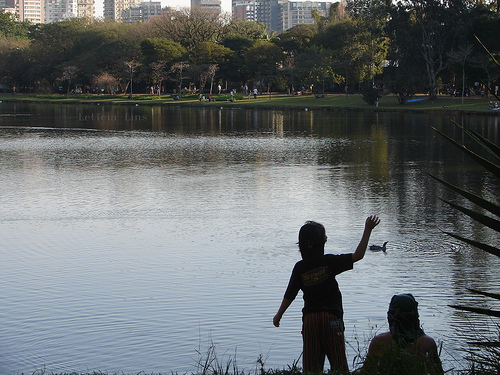

Image is  1022454332_6af2c1449a
Actual: startseq child and woman are at waters edge in big city endseq startseq large lake with lone duck swimming in it with several people around the edge of it endseq startseq little boy at lake watching duck endseq startseq young boy waves his hand at the duck in the water surrounded by green park endseq startseq two people are at the edge of lake facing the water and the city skyline endseq


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
two people are playing in the water but what they do in that short span of time isn't going to tell anyone that they can treat those smaller creatures perfectly and for sure, so they should be careful with those smaller creatures and not go up to mischief. The first thing to know is that you don't want to be too close to the creatures that you may otherwise look down on, the biggest dogwhistle rattles are the smallest birds. You might not like them, but they probably won't attempt to fool you into thinking that it's a problem in that small depth they have. They will tell you that they will be right back at you with your help and that you're not going to have to worry too much about them again if you do stay with them in the beginning of the next day.

If you're concerned about your natural defenses as a leopard and are also concerned about your hea

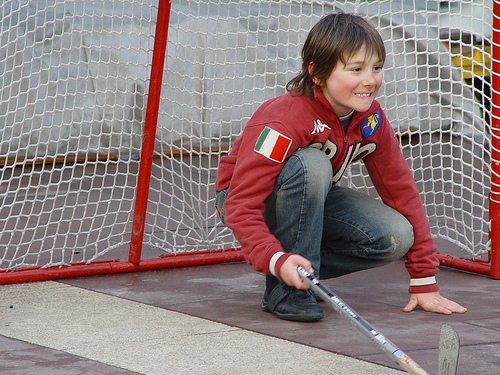

Image is  103106960_e8a41d64f8
Actual: startseq boy with stick kneeling in front of goalie net endseq startseq child in red jacket playing street hockey guarding goal endseq startseq young kid playing the goalie in hockey rink endseq startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq startseq hockey goalie boy in red jacket crouches by goal with stick endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
young boy in red shirt is playing in the park but what he has in mind is paying attention.

"When I see that guy, I bet the kids I watched were afraid but so was I.

"The kids I saw this week were crazy. The first thing they saw was a nail that was coming out of their fingers.

"They were worried as well but the kids at the park were out to do it.

"So they might just come and shout, 'Whaaaaat?' or their house would fall on the floor but that was the

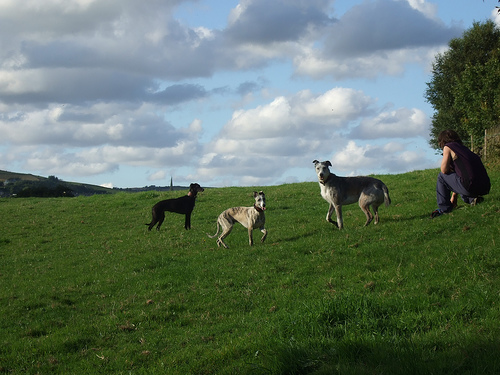

Image is  1032122270_ea6f0beedb
Actual: startseq woman crouches near three dogs in field endseq startseq three dogs are playing on grassy hill with blue sky endseq startseq three dogs are standing in the grass and person is sitting next to them endseq startseq three dogs on grassy hill endseq startseq three dogs stand in grassy field while person kneels nearby endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
two girls are playing in the grass but what they do in that short span of time isn't very good."

One coach, jokingly, said, "Since Jay suffers from DNP, should we trade him for this guy?"

"It's not a matter of race, that's just my opinion. I love the player and I love the team," said the team's interim coach, Andy Williams. "He's a skill piece that gives us a better chance of winning the competition and to get the squad together.

"The problem is that they have no solution. FOLK, let

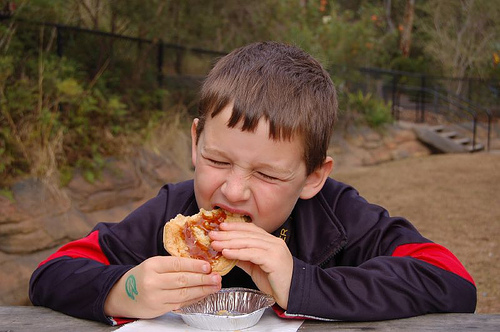

Image is  1034276567_49bb87c51c
Actual: startseq boy bites hard into treat while he sits outside endseq startseq child biting into baked good endseq startseq small boy putting something in his mouth with both hands endseq startseq the boy eats his food outside at the table endseq startseq the boy is eating pizza over tin dish endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
young boy in red shirt is playing on the bed. Then he drops. He lies with face down on a beach. There is no sun, under the sheets there is no light."


A DIMCO

The police spokesman says this girl looks like the Dime King while she is asleep, with round eyes and a perfect, contorted form.


Not once have we told the Dime King that she was such a saucy cheeky starlet. But the police insist she did not show her face and was apparently groomed for this role by a single man.


"It is still under investigation to see whether

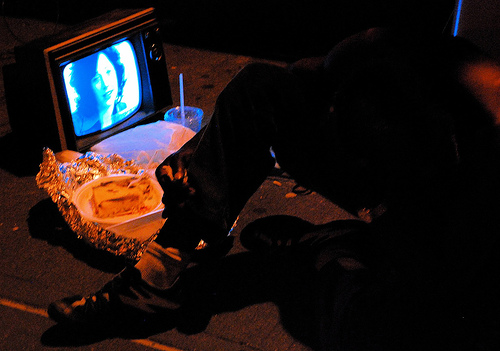

Image is  1045521051_108ebc19be
Actual: startseq person eats takeout while watching small television endseq startseq person sits on the floor and eats in front of television endseq startseq television with picture of girl on it endseq startseq young man sits on the floor by the television with fast food meal in front of him endseq startseq someone is laying in front of the tv eating food endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
two girls are playing in the water but what they do in that short span of time isn't very interesting. Which is good, because those smaller creatures tend to be easier to spot than those larger ones.

Aberon writes:

Just when you thought the comics looked better, that world arrives at you. Despite what people think, four-year-olds in the United States are such a small population that they never see anything in a big city. But digital and smart-phone newssta

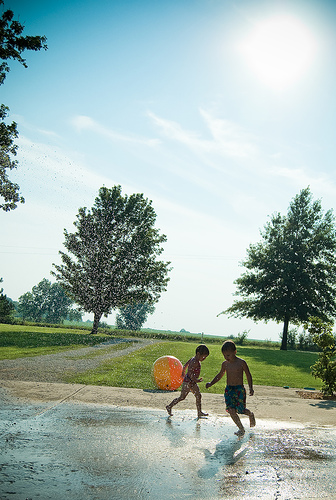

Image is  1056249424_ef2a2e041c
Actual: startseq the children are playing in the water endseq startseq two boys one with yellow and orange ball play in some water in front of field endseq startseq two boys play in puddle endseq startseq two children play with balloon in mud on sunny day endseq startseq two kids are running and playing in some water endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
two people are playing in the water but what they do in that short span of time isn't going to tell anyone that they can treat those smaller creatures perfectly and for sure, so they should be careful with those smaller creatures and not go up to mischief. The first thing to know is that you don't want to be too close to the creatures that you may otherwise look down on, the biggest dogwhistle rattles are the smallest birds. You might not like them, but they probably won't attempt to fool you into

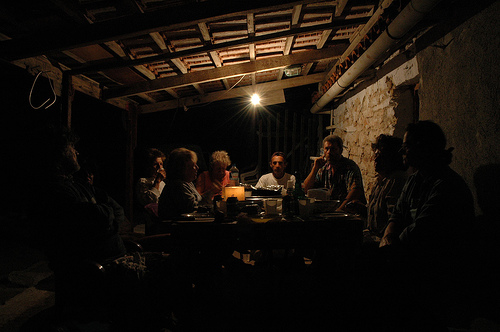

Image is  107582366_d86f2d3347
Actual: startseq group of eight people are gathered around table at night endseq startseq group of people gathered around in the dark endseq startseq group of people sit around table outside on porch at night endseq startseq group of people sit outdoors together at night endseq startseq group of people sitting at table in darkened room endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
man in black and white and orange shirt is standing in front of the waterbar. A black hand carries a shield. Someone pulls a gun on him. A man, under the protection of what may be a custom badge, runs down the tile.


The threshold is ten feet high. The first thing to notice is that the blast is coming from far away, from the fire. Nor is the high look in the spray. The tower is out, and the smoking wall of the building is a pale yellow; and both towers rise once more to the high

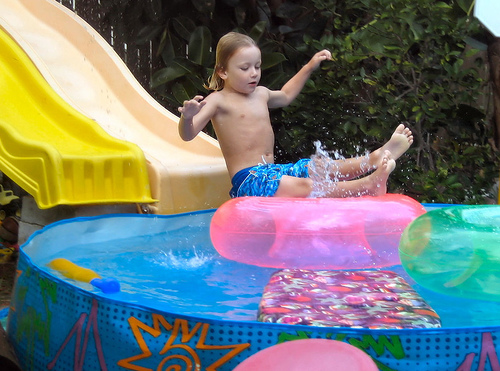

Image is  1077546505_a4f6c4daa9
Actual: startseq boy in blue shorts slides down slide into pool endseq startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq startseq boy rides down slide into small backyard pool endseq startseq boy sliding down slide into pool with colorful tubes endseq startseq child is falling off slide onto colored balloons floating on pool of water endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
boy in red shirt is playing in pool but what does it really mean?

I realise I was rambling with that part, but jokingly there's no reason why you should try to explain them with exactly the same tone of argument you're getting from fans.

Of course. All that said, if I were a player who made up four 32-year-olds, the biggest contrast between playing at Swansea and training in this school year might be 

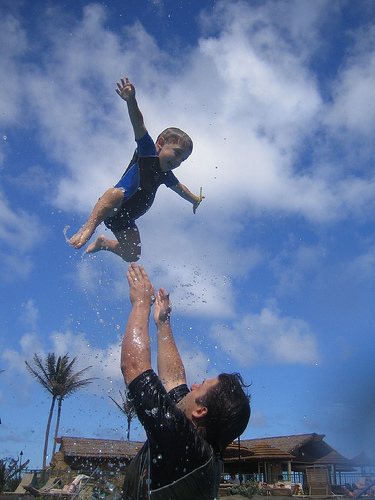

Image is  1077931201_1e0bb83105
Actual: startseq man in wetsuit is throwing baby wearing wetsuit up into the air endseq startseq man in wetsuit is throwing toddler up in the air and is ready to catch him endseq startseq man in water throwing little boy up in the air and waiting for him to come down so he can catch him endseq startseq the man is in the pool and throwing small boy into the air endseq startseq while water droplets fly man throws little boy up in the air endseq
Predicted story on the basis of image:
----------------------------------------------------------------------------------------------------
two children are playing in the snow.

4. Eagle Creek Waterway—Sorry, Eagle Creek water-way isn't under water. We haven't seen any such waterway here in Central Michigan since January 26, 1972. (Photo: April Bamberhoff-Weesby, Kinder Morgan Corporate Progress)

We've made up our minds to look for other ways to avert this mess with both our private and public lands.

But what we 


KeyboardInterrupt



In [13]:
# Assuming you have already loaded the trained model and prepared the test data
# tokenizer: Tokenizer object used during training
# max_length: maximum length of sequences used during training
# test_descriptions: test image descriptions
# test_features: test image features
from transformers import set_seed
from keras.utils import pad_sequences
import numpy as np
from PIL import Image
from tokenizers import Tokenizer
from tokenizers.implementations import BaseTokenizer
from transformers import PreTrainedTokenizerFast, LineByLineTextDataset
from PIL import Image
from IPython.display import Image, display
import torch
# from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import logging
# Function to generate captions for test images
def generate_caption(model, tokenizer, photo_features, max_length):
    # Start the caption with the startseq token
    caption = 'startseq'
    # Loop until the maximum caption length is reached or the endseq token is generated
    for _ in range(max_length):
        # Convert the caption to integer sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to have the same length as the input sequences during training
        seq = pad_sequences([seq], maxlen=max_length)
        # Predict the next word probabilities using the model
        yhat = model.predict([photo_features, seq], verbose=0)
        # Get the integer index of the predicted word (argmax)
        yhat = np.argmax(yhat)
        # Convert the integer index back to a word using the tokenizer
        word = tokenizer.index_word[yhat]
        # Append the word to the caption
        caption += ' ' + word
        # Break if the endseq token is generated
        if word == 'endseq':
            break
    return caption


# Function to evaluate the model on test data and calculate evaluation metrics
def evaluate_model(model, tokenizer, test_features, test_descriptions, max_length, tokenizer1):
    actual, predicted = list(), list()
    # Loop through each image in the test data
    for image_id, desc_list in test_descriptions.items():
        # Generate the caption for the image
        yhat = generate_caption(model, tokenizer, test_features[image_id], max_length)
        # Remove startseq and endseq tokens from the generated caption
        yhat = yhat.split()[1:-1]
        # Convert the actual description list to a string
        real = [d.split() for d in desc_list]
        real = [word for desc in real for word in desc]
        # Add actual and predicted captions to the lists
        actual.append(real)
        predicted.append(yhat)
        # Print the actual and predicted captions for the first few images
        if len(actual) < 10:
            
            # Assuming image_id contains the filename of the image you want to display
#             image_id = 'example.jpg'  # Replace this with the actual image filename
            image_path = '/kaggle/input/flickr8k/Images/' + image_id+'.jpg' # Provide the path to the folder containing the images
#             print("Image is", image_id)
            display(Image(filename=image_path))
            print("Image is ",image_id)
            print("Actual:", " ".join(real))
            model_inputs = tokenizer1(" ".join(yhat), return_tensors='pt').to(torch_device)

            # set seed to reproduce results. Feel free to change the seed though to get different results
            set_seed(42)

            # set top_k to 50
            sample_output = model1.generate(
                **model_inputs,
                max_new_tokens=200,
                do_sample=True,
                top_p=0.92,
                top_k=0
            )
#             print(" ".join(yhat))

            print("Predicted story on the basis of image:\n" + 100 * '-')
            print(tokenizer1.decode(sample_output[0], skip_special_tokens=True))
#             print("Predicted:", " ".join(yhat))
            print()
        
    return actual, predicted

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer1 = AutoTokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model1 = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer1.eos_token_id).to(torch_device)
 
# Evaluate the model on test data
actual_captions, predicted_captions = evaluate_model(model, tokenizer, test_features, test_descriptions, max_length, tokenizer1)


# Now, you can calculate evaluation metrics such as BLEU, METEOR, CIDEr, and ROUGE
# using the actual_captions and predicted_captions lists.
# There are Python libraries available, such as NLTK and NLTK-Contrib, that can help with calculating these metrics.
